# Train model for all glaciers, random k-fold cv


In [44]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import xgboost as xgb

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction

In [45]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


C:\Users\kasj\AppData\Local\Temp\ipykernel_5828\1510741197.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


### Using the same test glaciers as in "train_model_blocking_by_glacier"

In [46]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

In [4]:
# Run with different random seeds
rand_seed = 25

# Training with random 5-fold cv with temperature and precipitation

In [49]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

In [48]:
# Select features for training
df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y = select_variables(df_train, label_cols)

X_train, y_train = df_train_X.values, df_train_y.values

In [7]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

### Train model

In [8]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [9]:
# Train model
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

In [11]:
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')
cv_grid = joblib.load('Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')

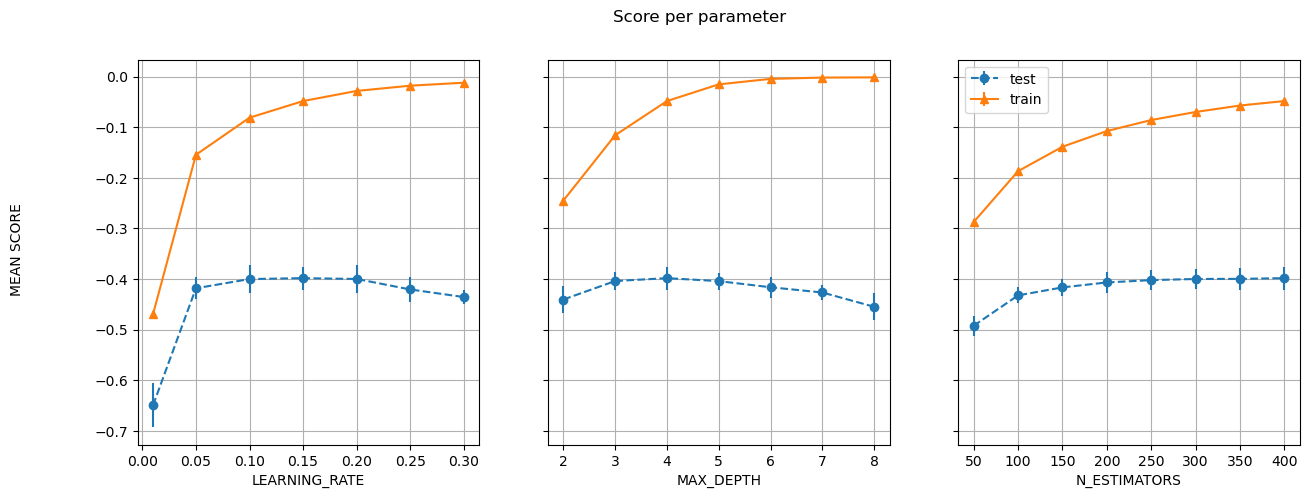

In [12]:
plot_gsearch_results(cv_grid)

In [13]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [15]:
cvl = cross_val_score(fitted_model, X_train, y_train, cv=splits, scoring='neg_mean_squared_error')
print(cvl)

[-0.40122302 -0.40422843 -0.4348377  -0.36638728 -0.38427638]


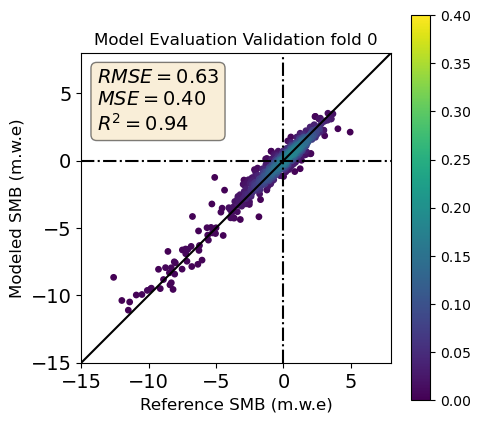

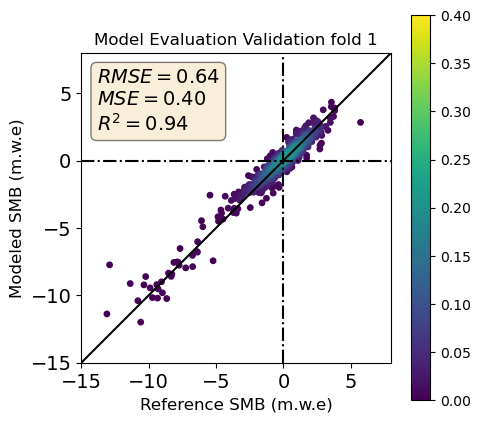

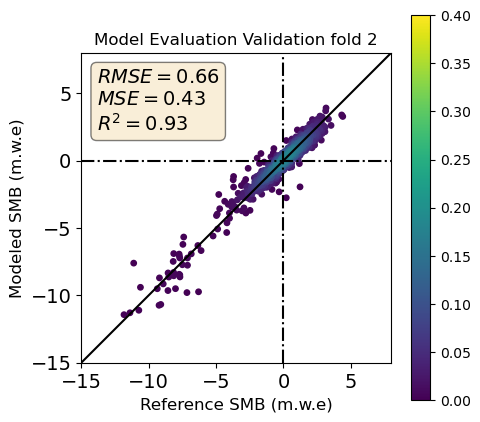

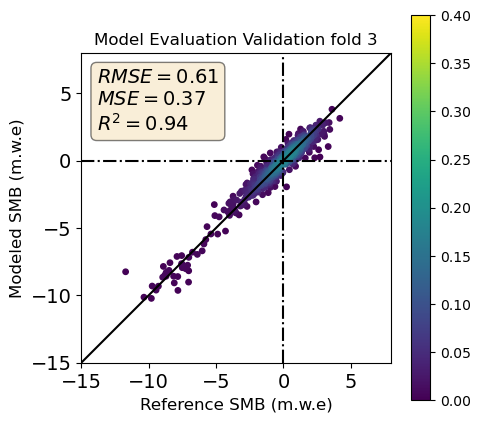

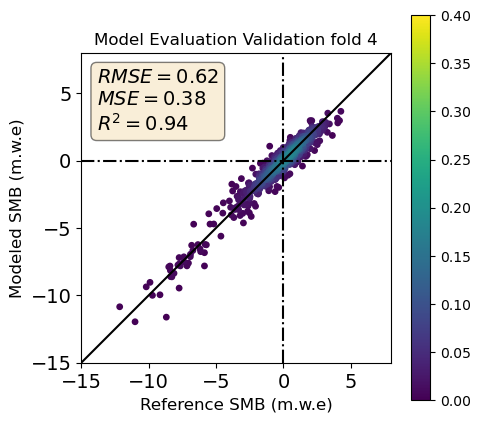

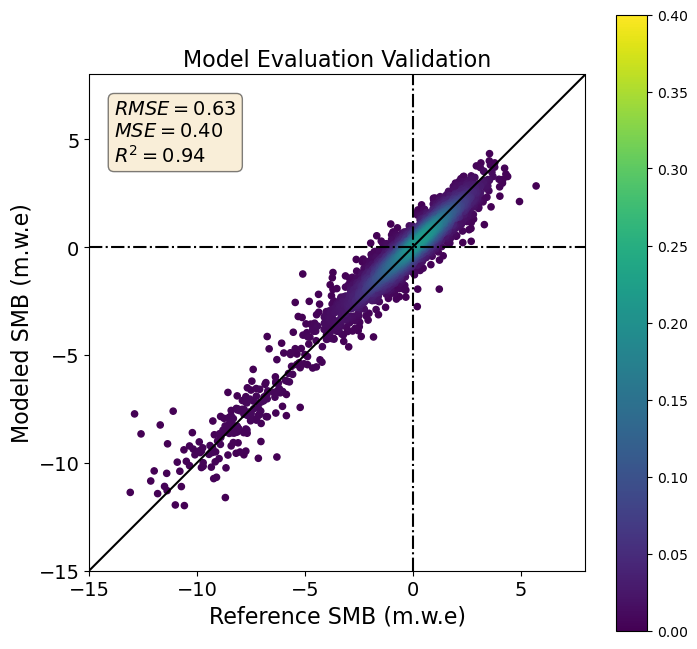

In [16]:
plot_prediction_per_fold(X_train, y_train, fitted_model, splits)

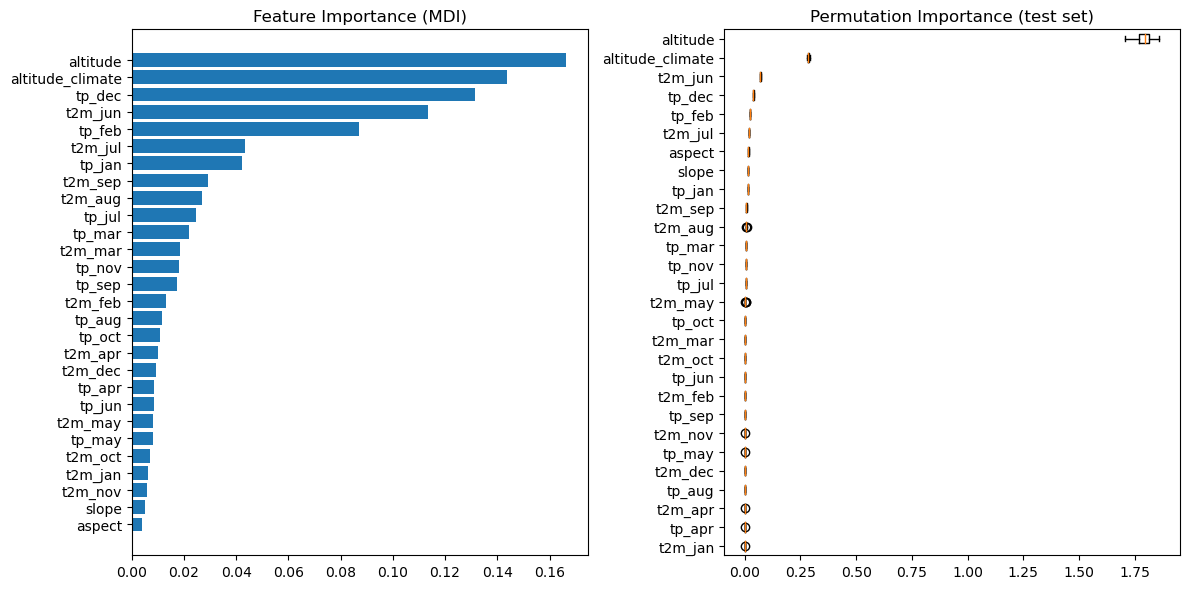

In [13]:
from sklearn.inspection import permutation_importance

best_model.fit(X_train, y_train)
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    best_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with random 5-fold cv with all climate features

### Select features and prepare data for training

In [18]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

df_train_X = df_train.drop(drop_cols, axis=1)
df_train_y = df_train[['balance_netto']]

X_train, y_train = df_train_X.values, df_train_y.values

In [30]:
df_train_X

,altitude,aspect,slope,slope_factor,u10_oct,u10_nov,u10_dec,u10_jan,u10_feb,u10_mar,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
189,990.0,2.509464,0.238202,2.365011,0.987576,-0.182683,-0.089565,0.802768,0.236348,-0.376631,...,0.005483,0.003681,0.002447,0.003016,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943
190,996.0,2.474161,0.117946,3.605711,0.005267,-0.816228,0.717362,1.935894,-0.130982,-0.119557,...,0.012715,0.002994,0.002428,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943
191,988.0,2.509464,0.238202,2.365011,0.603107,-0.514308,-1.539177,-0.466036,-1.326092,-1.272106,...,0.001472,0.000642,0.003090,0.001900,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943
192,990.0,2.478294,0.146882,3.160964,-0.381773,-0.191252,-2.336107,-0.223529,-0.287798,-0.262661,...,0.003862,0.002945,0.003645,0.003376,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943
193,990.0,2.478294,0.146882,3.160964,-0.579148,-0.523735,-0.820798,-0.986182,0.486567,0.527984,...,0.001893,0.004887,0.004874,0.004694,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,1151.4,3.229342,0.093474,3.872423,-1.033313,-0.855646,-0.091279,-0.663411,-1.093011,-0.443470,...,0.007993,0.006946,0.009393,0.007489,0.003727,0.008407,0.008133,0.007797,0.006275,903.493549
3834,1196.0,3.752693,0.116894,3.625141,-1.051879,-0.768812,-0.023011,-0.567723,-1.077872,-0.414050,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689
3835,1399.5,3.996078,0.040634,3.872423,-1.051879,-0.768812,-0.023011,-0.567723,-1.077872,-0.414050,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689
3836,1513.3,3.214424,0.043804,3.872423,-1.051879,-0.768812,-0.023011,-0.567723,-1.077872,-0.414050,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689


In [19]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

### Explore folds

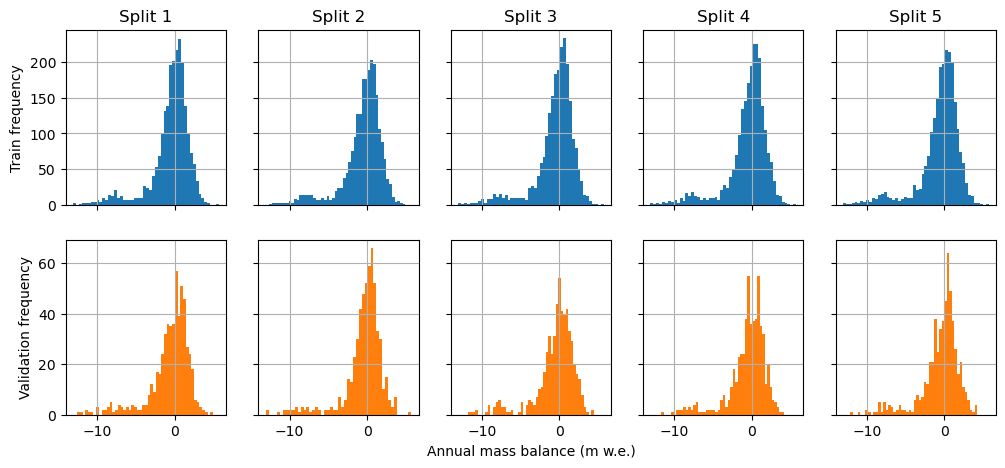

In [20]:
# Plot mass balance distributions of training and validation sets.
j=0
f, ax = plt.subplots(2, len(splits), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits)):
    if i>2:
        j=1
    df_train.iloc[splits[i][0]].balance_netto.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train.iloc[splits[i][1]].balance_netto.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Annual mass balance (m w.e.)')
    
for row in ax:
    for a in row:
        a.grid()

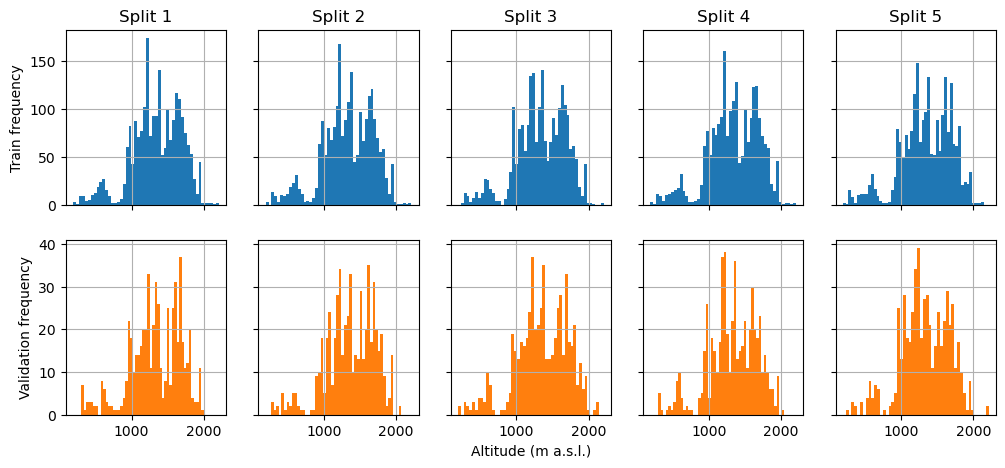

In [21]:
# Plot altitude distributions of training and validation sets.

j=0
f, ax = plt.subplots(2, len(splits), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits)):
    if i>2:
        j=1
    df_train.iloc[splits[i][0]].altitude.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train.iloc[splits[i][1]].altitude.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

### Train model

In [23]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [24]:
# Train model
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

In [25]:
# Save cv-object
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_all_climate_seed25.pkl')
cv_grid = joblib.load('Models/Random_5fold/cv_random_5fold_all_climate_seed25.pkl')

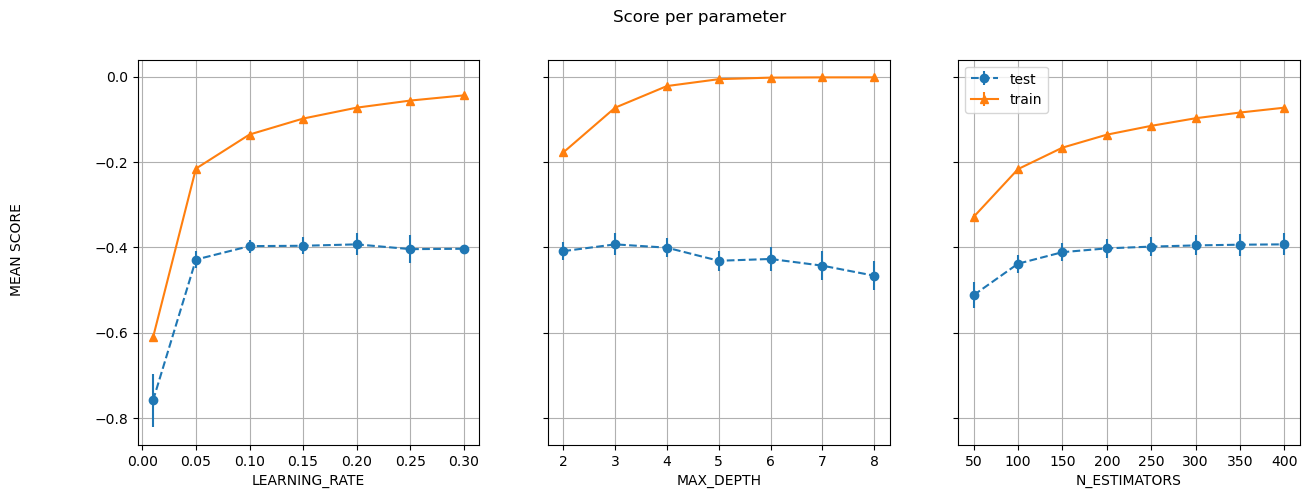

In [26]:
plot_gsearch_results(cv_grid)

In [27]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [28]:
cvl = cross_val_score(fitted_model, X_train, y_train, cv=splits, scoring='neg_mean_squared_error')
print(cvl)

[-0.37777406 -0.43846855 -0.38555264 -0.36192718 -0.40195378]


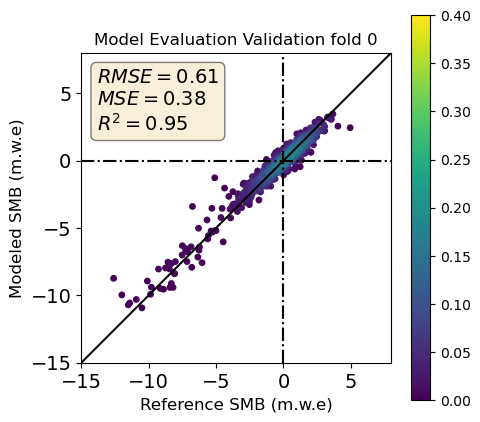

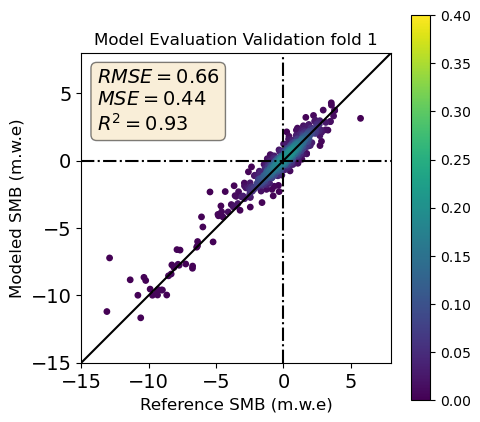

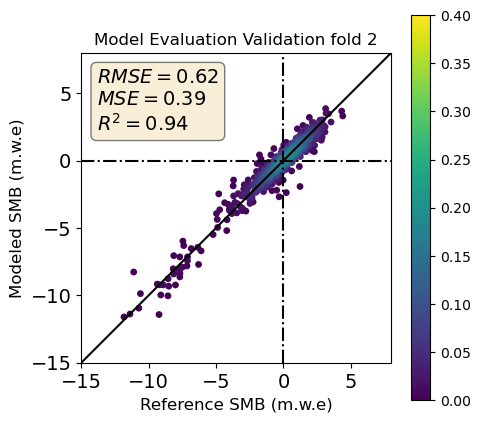

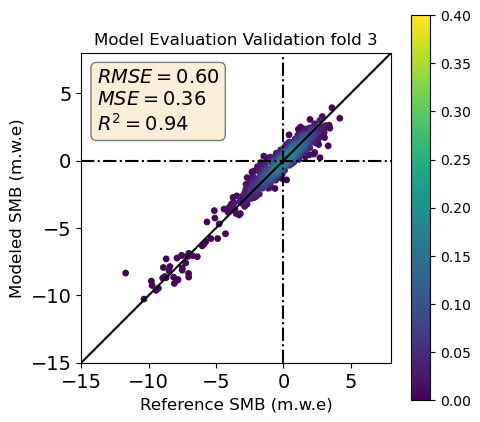

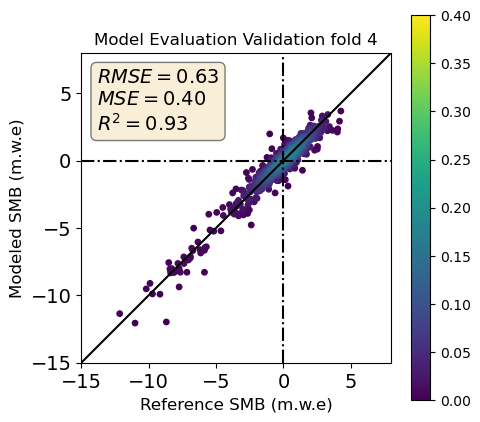

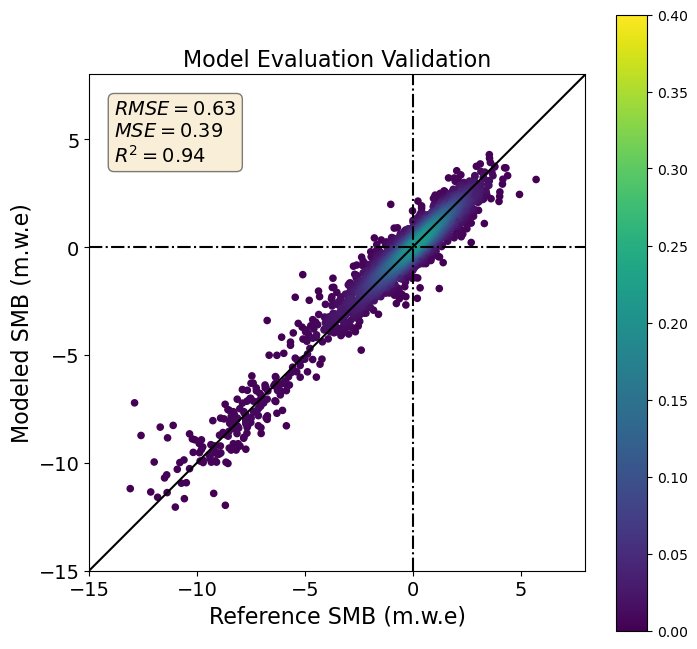

In [29]:
plot_prediction_per_fold(X_train, y_train, fitted_model, splits)

In [22]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train, y_train)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X.columns)[ind]

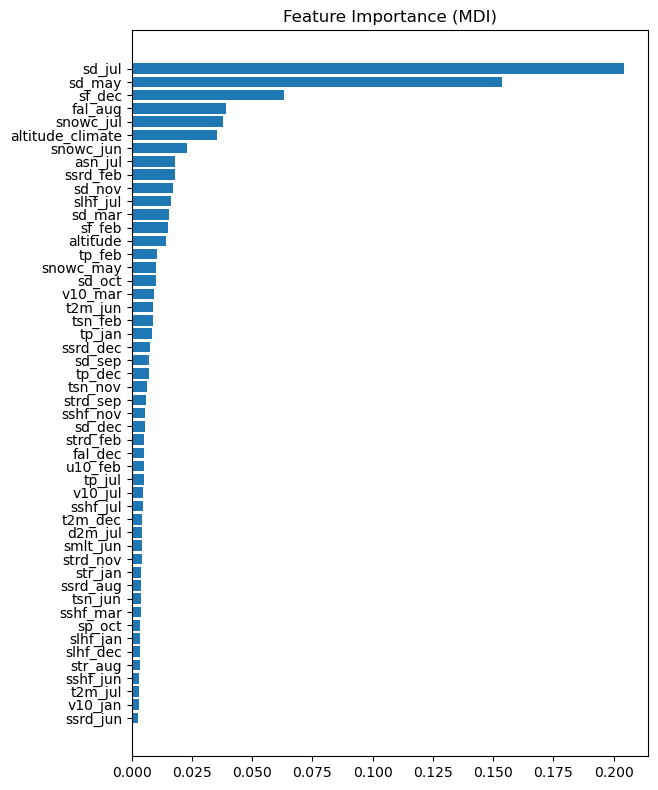

In [23]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with random 5-fold cv with minimal climate features (removing derived/redundant features)

### Select features and prepare data for training

In [31]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

df_train_X = df_train.drop(drop_cols, axis=1)
df_train_y = df_train[['balance_netto']]

X_train, y_train = df_train_X.values, df_train_y.values

In [32]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

### Train model

In [33]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
              'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
              'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [34]:
# Train model
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

In [35]:
# Save cv-object
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_minimal_climate_seed25.pkl')
cv_gird = joblib.load('Models/Random_5fold/cv_random_5fold_minimal_climate_seed25.pkl')

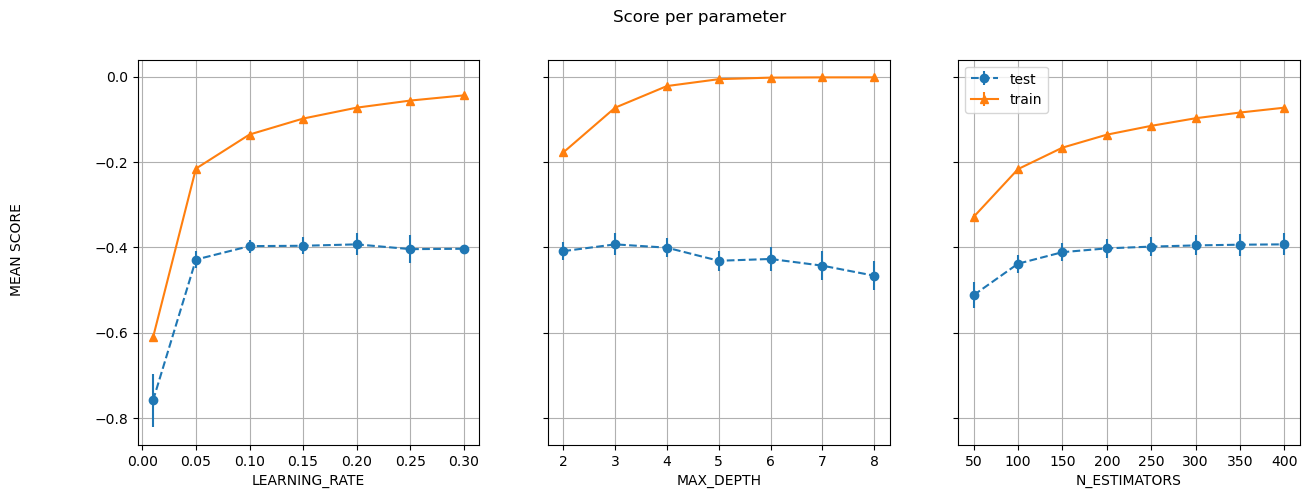

In [36]:
plot_gsearch_results(cv_grid)

In [37]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [38]:
cvl = cross_val_score(fitted_model, X_train, y_train, cv=splits, scoring='neg_mean_squared_error')
print(cvl)

[-0.37422756 -0.47188112 -0.41967032 -0.38956275 -0.41471582]


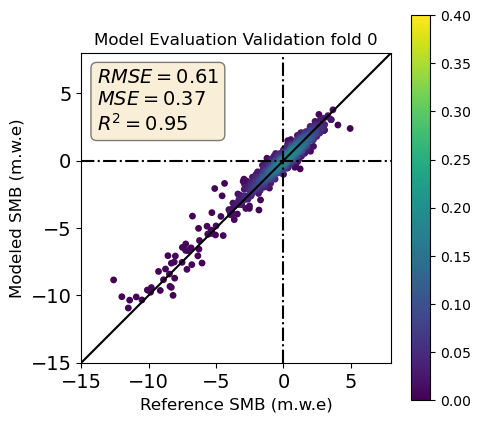

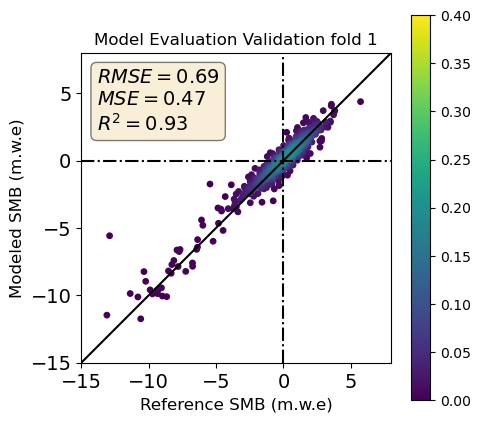

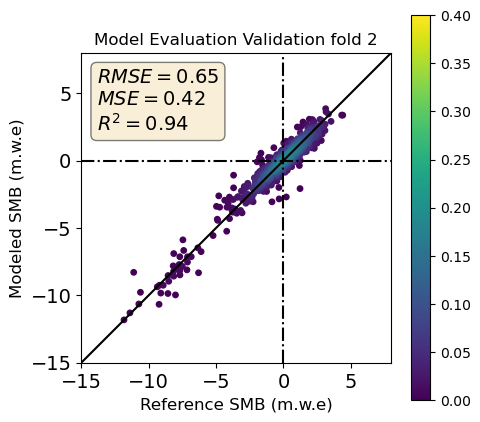

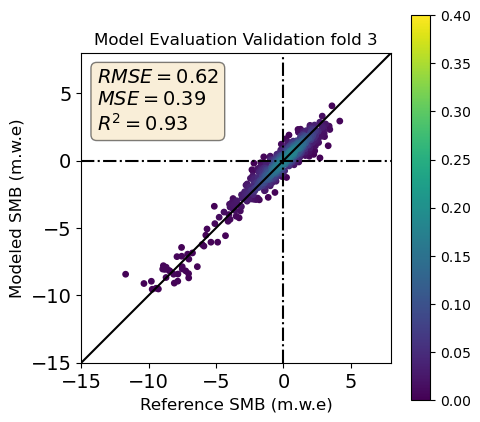

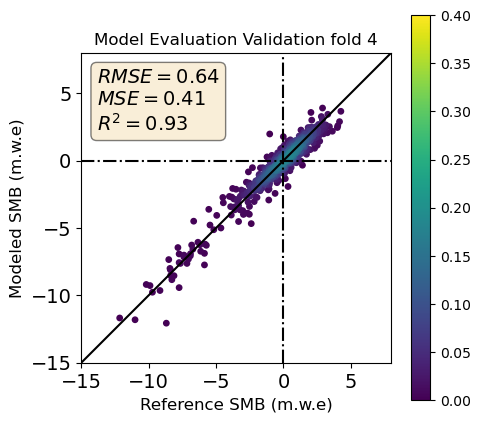

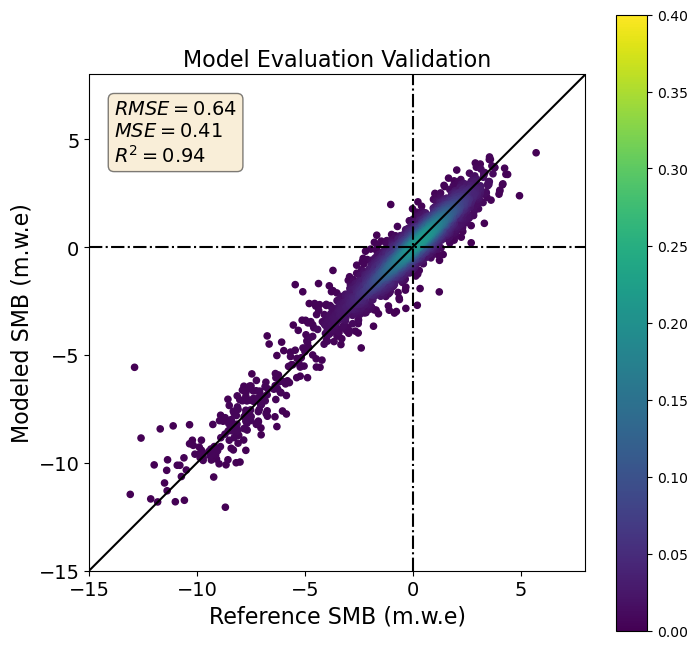

In [39]:
plot_prediction_per_fold(X_train, y_train, fitted_model, splits)

In [42]:
# Plot feature importance

max_features_plot = 50

fitted_model.fit(X_train, y_train)
feature_importance = fitted_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X.columns)[ind]

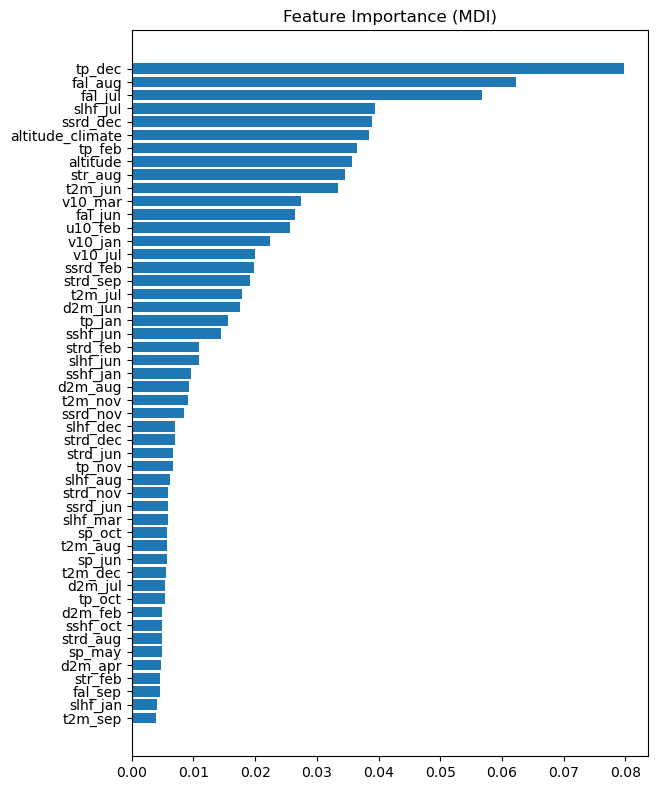

In [43]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

ssrd_dec is a proxy for latitude??